## Grad-CAM Explainability

In [1]:
# Setup: Import Libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from pathlib import Path
import os

In [2]:
# Load Fine-Tuned Model

# Load the best saved model
model = load_model("final_resnet50_finetuned.h5")

# Confirm model loaded and summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [3]:
# Load Class Labels

# Define class index mapping (ensure matches your training)
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [4]:
# Load and Preprocess a Test Image

def load_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # same scaling as training
    return img_array, img

In [5]:
# Example:

# Path to one of the test images
sample_path = Path(r'C:\Users\Admin\Downloads\Jupyter Notes\Projects\COVID-19_Chest_X-ray_Classification\COVID-19_Radiography_Dataset\Normal\Normal-10.png')

img_array, original_img = load_preprocess_image(sample_path)

In [6]:
# Grad-CAM Function

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [7]:
# Visualize Heatmap on Original Image

def display_gradcam(img_path, heatmap, original_img, alpha=0.4):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay[..., ::-1])  # Convert BGR to RGB
    plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 18s 18s/step
Predicted class: Normal


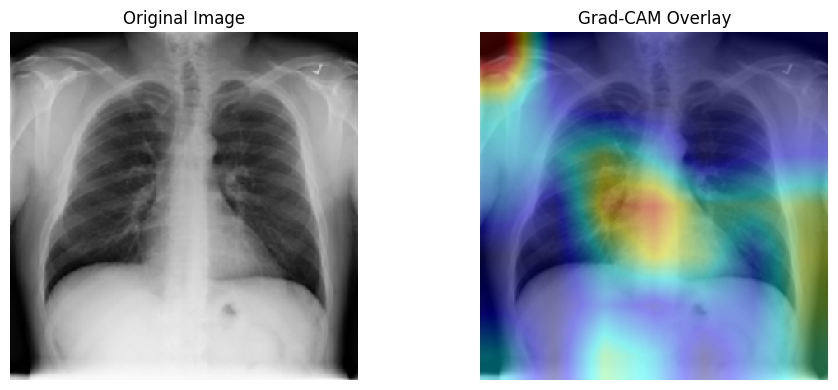

In [8]:
# Generate Grad-CAM Heatmap

# Replace with actual layer name (check model summary if needed)
last_conv_layer_name = "conv5_block3_out"  # for ResNet50

# Predict
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
print(f"Predicted class: {class_names[predicted_class]}")

# Create Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display
display_gradcam(sample_path, heatmap, original_img)

In [9]:
# Add predicted class & confidence:

preds = model.predict(img_array)
pred_class = np.argmax(preds[0])
confidence = preds[0][pred_class]
print(f"Predicted Class: {class_names[pred_class]} ({confidence:.2f})")

1/1 [==============================] - 0s 413ms/step
Predicted Class: Normal (1.00)


### Batch generate Grad-CAMs for multiple image

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

In [11]:
# Load and preprocess image

def load_preprocess_image(img_path, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    original_img = np.uint8(img_array)  # save original for display
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array, original_img

In [12]:
# Make Grad-CAM heatmap

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions[0].numpy()

In [13]:
# Display and save the Grad-CAM overlay

def display_and_save_gradcam(img_path, heatmap, original_img, pred_class_name, confidence, output_path, alpha=0.4):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    # Display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img.astype(np.uint8))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Prediction: {pred_class_name} ({confidence:.2f})")
    plt.imshow(overlay[..., ::-1])  # BGR to RGB
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Save image
    cv2.imwrite(str(output_path), overlay)

In [14]:
# Generate Grad-CAMs for batch of images

def generate_batch_gradcams(model, image_paths, class_names, last_conv_layer_name, output_dir="gradcam_outputs"):
    os.makedirs(output_dir, exist_ok=True)
    results = []

    for img_path in image_paths:
        img_array, original_img = load_preprocess_image(img_path)
        heatmap, prediction = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        pred_index = np.argmax(prediction)
        confidence = prediction[pred_index]
        pred_class_name = class_names[pred_index]

        # Output path
        filename = f"{img_path.stem}_gradcam_{pred_class_name}.png"
        output_path = Path(output_dir) / filename

        display_and_save_gradcam(
            img_path, heatmap, original_img,
            pred_class_name, confidence,
            output_path
        )

        results.append({
            "image": img_path.name,
            "predicted_class": pred_class_name,
            "confidence": float(confidence),
            "saved_path": str(output_path)
        })

    return results

In [15]:
# Automatically generate Grad-CAM for all 4 classes
# Save Grad-CAM overlay to disk
# Overlay predicted class label + confidence on the plots

# Example
test_image_paths = [
    Path(r'C:\Users\Admin\Downloads\Jupyter Notes\Projects\COVID-19_Chest_X-ray_Classification\COVID-19_Radiography_Dataset\COVID\COVID-10.png'),
    Path(r'C:\Users\Admin\Downloads\Jupyter Notes\Projects\COVID-19_Chest_X-ray_Classification\COVID-19_Radiography_Dataset\Normal\Normal-10.png'),
    Path(r'C:\Users\Admin\Downloads\Jupyter Notes\Projects\COVID-19_Chest_X-ray_Classification\COVID-19_Radiography_Dataset\Lung_Opacity\Lung_Opacity-10.png'),
    Path(r'C:\Users\Admin\Downloads\Jupyter Notes\Projects\COVID-19_Chest_X-ray_Classification\COVID-19_Radiography_Dataset\Viral Pneumonia\Viral Pneumonia-10.png')
]

In [16]:
# Class mapping
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

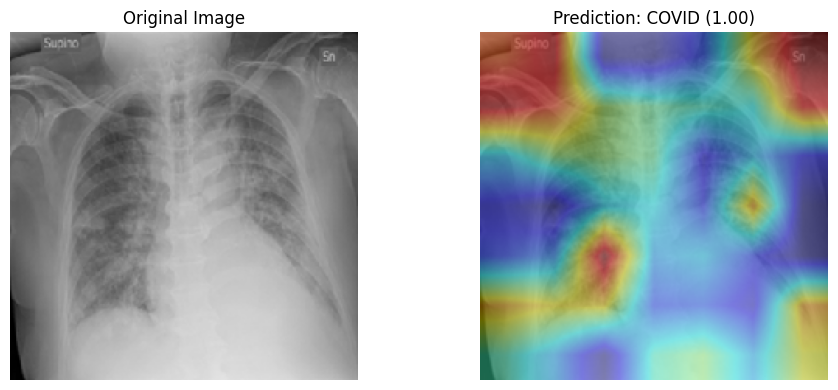

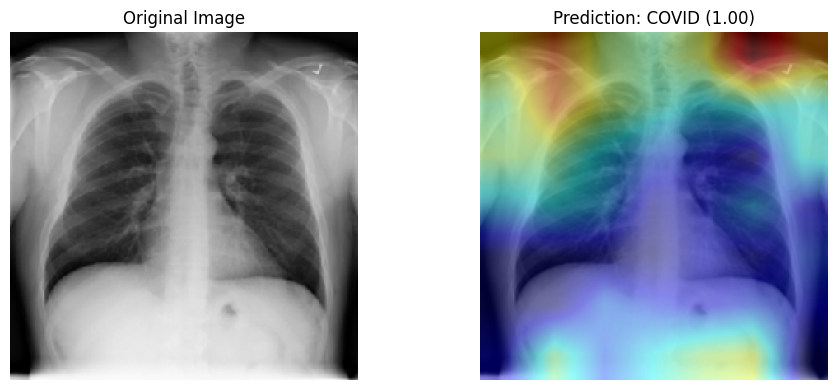

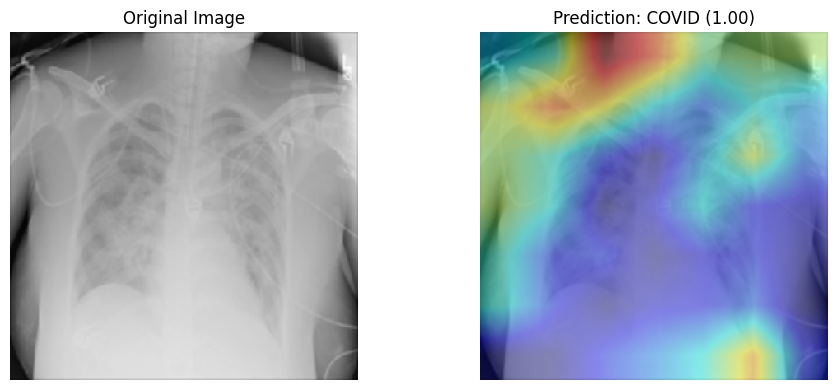

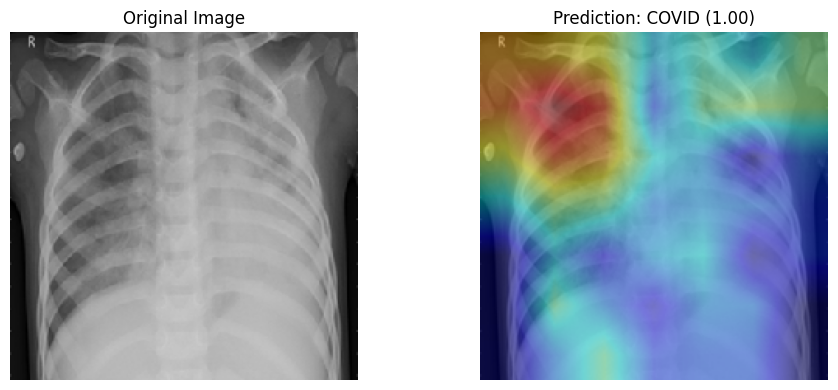

In [17]:
# Run batch Grad-CAM generation

results = generate_batch_gradcams(
    model=model,
    image_paths=test_image_paths,
    class_names=class_names,
    last_conv_layer_name="conv5_block3_out",  # or as per your ResNet model
    output_dir="gradcam_outputs"
)

### Automatically identify misclassified samples in batch Grad-CAMs

In [18]:
# Feed test_true_labels and test_image_paths to your Grad-CAM generation.
# Match predictions with true labels to identify misclassified samples.
# Overlay correct vs predicted class in the tit

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to dataset directory
data_dir = Path(r'C:\Users\Admin\Downloads\Jupyter Notes\Projects\COVID-19_Chest_X-ray_Classification\COVID-19_Radiography_Dataset')

# Image dimensions and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Re-initialize validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important! So labels align with filepaths
)

# Now define true labels and image paths
test_true_labels = val_generator.classes.tolist()
test_image_paths = val_generator.filepaths
class_names = list(val_generator.class_indices.keys())

Found 21165 images belonging to 4 classes.


In [21]:
from tensorflow.keras.models import Model

def generate_misclassified_gradcams(
    model,
    image_paths,
    true_labels,
    class_names,
    last_conv_layer_name,
    output_dir="gradcam_outputs_misclassified",
    max_samples=10
):
    os.makedirs(output_dir, exist_ok=True)
    misclassified_samples = []

    for img_path, true_label in zip(image_paths, true_labels):
        img = image.load_img(img_path, target_size=(224, 224))
        original_img = np.array(img)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        preds = model.predict(img_array, verbose=0)
        pred_class = np.argmax(preds[0])
        confidence = preds[0][pred_class]

        if pred_class != true_label:
            misclassified_samples.append({
                "img_path": img_path,
                "true_label": true_label,
                "pred_class": pred_class,
                "confidence": confidence,
                "original_img": original_img
            })

        if len(misclassified_samples) >= max_samples:
            break

    print(f"\nGenerating Grad-CAMs for {len(misclassified_samples)} misclassified samples...")

    for i, sample in enumerate(misclassified_samples):
        img_path = sample["img_path"]
        pred_class = sample["pred_class"]
        true_label = sample["true_label"]
        confidence = sample["confidence"]
        original_img = sample["original_img"]

        # Grad-CAM generation
        grad_model = Model(
            [model.inputs], 
            [model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(np.expand_dims(original_img, axis=0) / 255.0)
            class_channel = predictions[:, pred_class]

        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap = heatmap.numpy()

        # Overlay heatmap
        img_cv = cv2.imread(str(img_path))
        img_cv = cv2.resize(img_cv, (224, 224))
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(heatmap_color, 0.4, img_cv, 0.6, 0)

        # Save
        base_name = Path(img_path).stem
        file_name = f"{i+1:02d}_{base_name}_GT-{class_names[true_label]}_Pred-{class_names[pred_class]}_{confidence:.2f}.png"
        save_path = os.path.join(output_dir, file_name)
        cv2.imwrite(save_path, overlay[..., ::-1])  # BGR to RGB for saving

        # Optionally, display
        plt.figure(figsize=(6, 3))
        plt.imshow(overlay[..., ::-1])
        plt.title(f"GT: {class_names[true_label]} | Pred: {class_names[pred_class]} ({confidence:.2f})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return misclassified_samples


Generating Grad-CAMs for 10 misclassified samples...


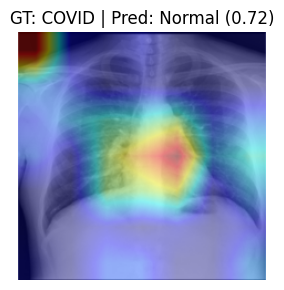

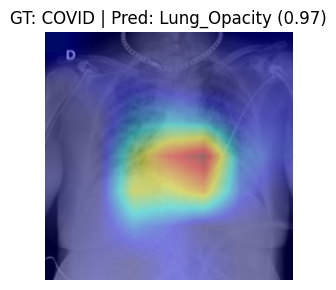

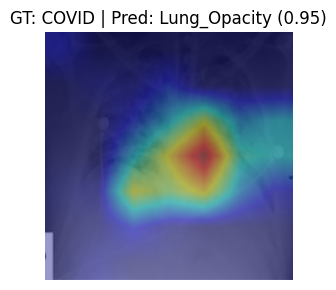

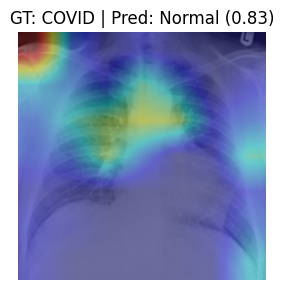

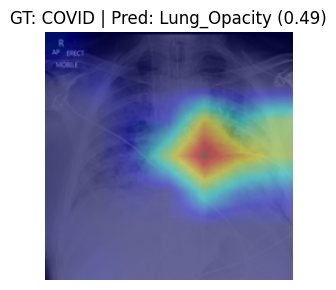

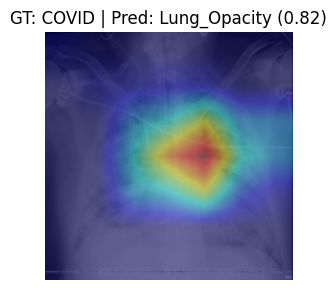

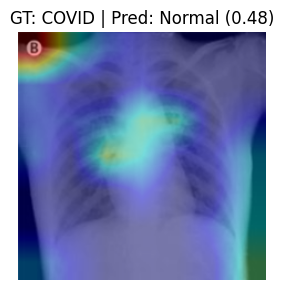

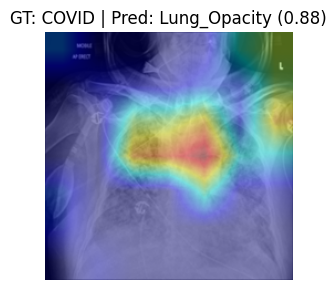

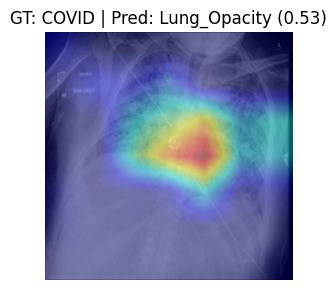

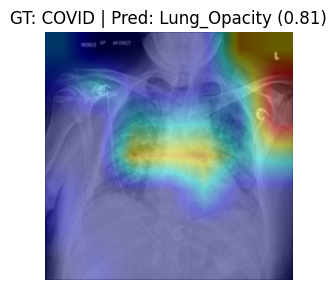

In [22]:
misclassified_results = generate_misclassified_gradcams(
    model=model,
    image_paths=test_image_paths,
    true_labels=test_true_labels,
    class_names=class_names,
    last_conv_layer_name="conv5_block3_out",
    output_dir="gradcam_outputs_misclassified",
    max_samples=10
)

### Grad-CAM for Top 5 Lowest-Confidence Misclassifications

In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    original_img = np.array(img).astype("uint8")
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, original_img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), predictions.numpy()[0]

def display_and_save_gradcam(img_path, heatmap, original_img, title, output_path, alpha=0.4):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    # Save to disk
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, overlay)

    # Also display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(overlay[..., ::-1])  # Convert BGR to RGB
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def generate_top5_lowconfidence_misclassified_gradcams(model, image_paths, true_labels, class_names, last_conv_layer_name, output_dir="gradcam_top5_lowconf"):
    results = []

    for img_path, true_label in zip(image_paths, true_labels):
        img_array, original_img = load_and_preprocess_image(img_path)
        heatmap, preds = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        pred_label = np.argmax(preds)
        confidence = preds[pred_label]

        is_misclassified = pred_label != true_label
        results.append({
            "img_path": img_path,
            "true_label": true_label,
            "pred_label": pred_label,
            "confidence": confidence,
            "original_img": original_img,
            "heatmap": heatmap,
            "is_misclassified": is_misclassified
        })

    # Filter misclassified only
    misclassified = [r for r in results if r["is_misclassified"]]
    if len(misclassified) == 0:
        print("No misclassifications found.")
        return []

    # Sort by lowest confidence
    misclassified_sorted = sorted(misclassified, key=lambda x: x["confidence"])[:5]

    for i, sample in enumerate(misclassified_sorted):
        img_path = sample["img_path"]
        heatmap = sample["heatmap"]
        original_img = sample["original_img"]
        true_class = class_names[sample["true_label"]]
        pred_class = class_names[sample["pred_label"]]
        confidence = sample["confidence"]
        title = f"Pred: {pred_class} ({confidence:.2f}) | GT: {true_class}"

        filename = os.path.basename(img_path).split(".")[0]
        save_path = os.path.join(output_dir, f"{filename}_misclassified_{i+1}.png")

        display_and_save_gradcam(img_path, heatmap, original_img, title, save_path)

    return misclassified_sorted

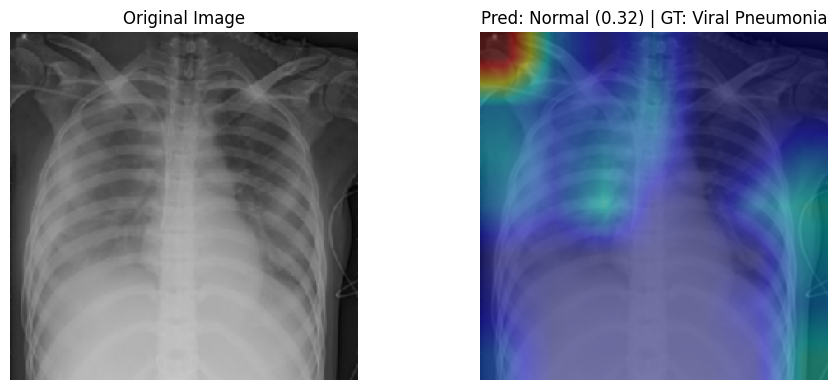

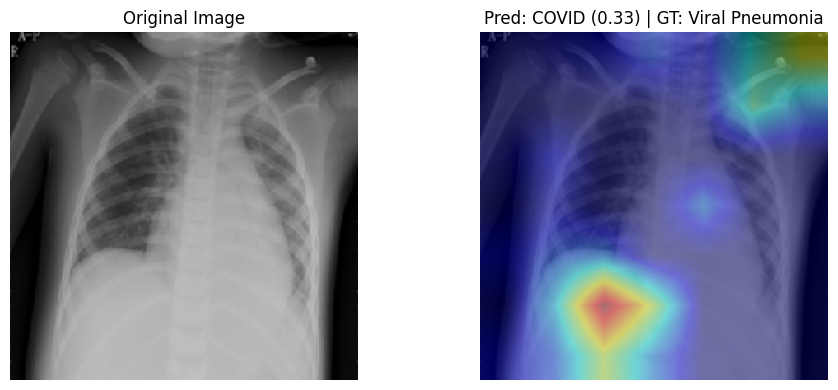

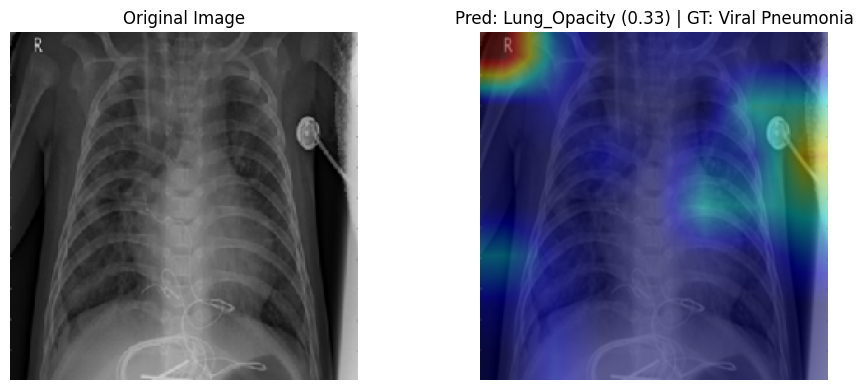

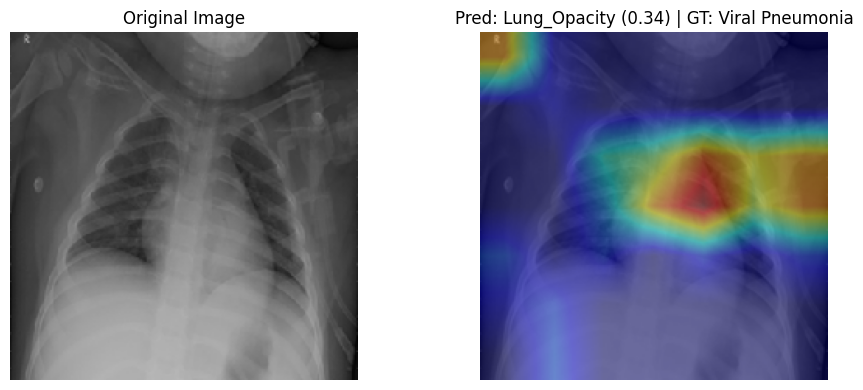

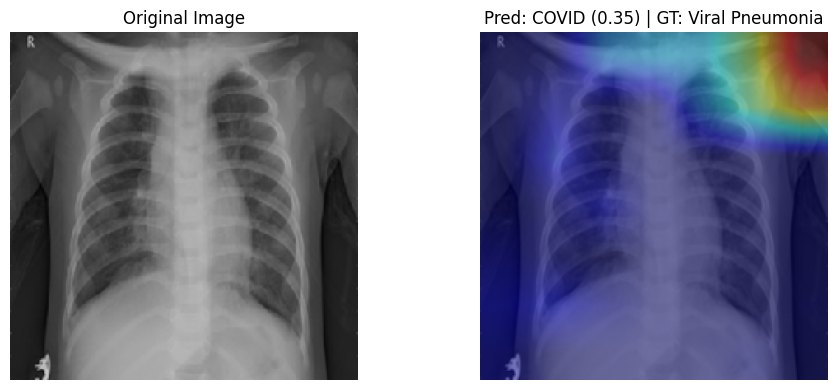

In [27]:
top5_errors = generate_top5_lowconfidence_misclassified_gradcams(
    model=model,
    image_paths=test_image_paths,
    true_labels=test_true_labels,
    class_names=class_names,
    last_conv_layer_name="conv5_block3_out",
    output_dir="gradcam_top5_lowconf"
)